In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [2]:
#Fares disponibles
f = [500,400,300,200,100]
m = len(f) 

#Probabilidad de llegada de un comprador (arraibal probablity)
lambd = 0.3

# Parametro que modela la disponibilidad a pagar (Willnes to pay)
beta= 0.5

#Capacidad de la aeronave
C = 50

#Horizonte temporal máximo
T = 50

# Porbabilidad de reserva de un producto f
p_j_acumulada = np.exp(-beta*(f/np.min(f)-1))

def pacum2pproduct(p_acumulada):
    p_j = []
    p_j.append(p_acumulada[0])
    for i in range(1,len(p_acumulada)):
        diff = -p_acumulada[i-1]+p_acumulada[i]
        p_j.append(diff)
    return p_j

def p_reserva(p_j,z,model = "diferenciable"):
    if z == []:
        return 0
    else:
        if model == "diferenciable":
            return p_j[list(z)].sum()
        
        if model == "pricebale":
            return p_j[0:np.max(z)].sum()

def expected_revenue(p_j,f,z,model = "diferenciable"):
    if z == []:
        return 0
    if model == "diferenciable":
        Q = 0
        for j in z:
            Q += p_j[j]*f[j]
        return Q 
    
    if model == "pricebale":
        return p_reserva(p_j,z,model)*f[np.max(z)]

p_j = np.array(pacum2pproduct(p_j_acumulada))


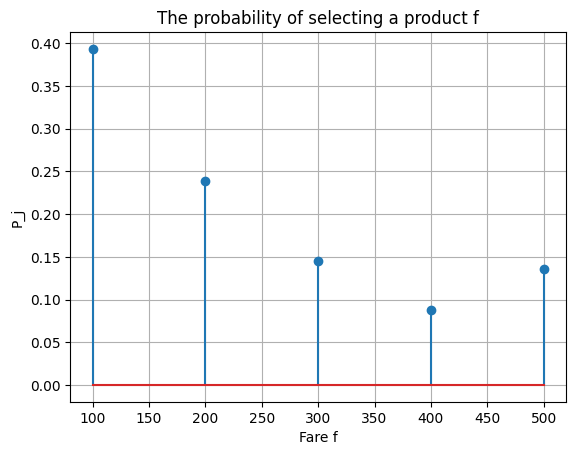

In [3]:

# Graficar la función exponencial
plt.stem(f, p_j)
plt.xlabel('Fare f')
plt.ylabel('P_j')
plt.title('The probability of selecting a product f')
plt.grid(True)
plt.show()

In [6]:
from itertools import combinations

def combinaciones_de_n(n):
    conjunto_N = set(range(0, n))  # Crear el conjunto N

    todas_combinaciones = []
    todas_combinaciones.append(())
    # Generar todas las combinaciones posibles del conjunto
    for r in range(1, n + 1):
        combinaciones_de_r = combinations(conjunto_N, r)
        todas_combinaciones.extend(list(combinaciones_de_r))

    return [list(tupla) for tupla in todas_combinaciones]

# Ejemplo de uso
m = len(f)  # Puedes ajustar n según el tamaño del conjunto
all_comb = combinaciones_de_n(m)
vec_Q_price = []
vec_Q_diff = []
vec_TR_price =  []
vec_TR_diff = []

for comb in all_comb:
    vec_Q_diff.append(p_reserva(p_j,comb,model = "diferenciable"))
    vec_Q_price.append(p_reserva(p_j,comb,model = "pricebale"))
    vec_TR_price.append(expected_revenue(p_j,f,comb,model = "pricebale"))
    vec_TR_diff.append(expected_revenue(p_j,f,comb,model = "diferenciable"))

def conjuntos_secuenciales(m):
    conjuntos_secuenciales = [[]] + [list(range(i + 1)) for i in range(m + 1)]
    return conjuntos_secuenciales

# Ejemplo de uso
m = len(f)- 1 
sec_com = conjuntos_secuenciales(m)
vec_Q_price_sec = []
vec_Q_diff_sec = []
vec_TR_price_sec =  []
vec_TR_diff_sec = []

for conjunto in sec_com:
    vec_Q_price_sec.append(p_reserva(p_j,conjunto,model = "pricebale"))
    vec_Q_diff_sec.append(p_reserva(p_j,conjunto,model = "diferenciable"))
    vec_TR_price_sec.append(expected_revenue(p_j,f,conjunto,model = "pricebale"))
    vec_TR_diff_sec.append(expected_revenue(p_j,f,conjunto,model = "diferenciable"))



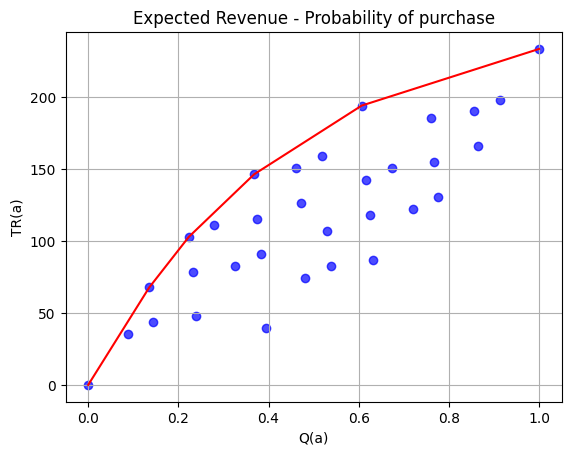

In [7]:
BP = 200
plt.scatter(vec_Q_diff, vec_TR_diff,label= "TR(a)", color='blue', alpha=0.7)  # Crear la nube de puntos
plt.plot(vec_Q_diff_sec, vec_TR_diff_sec,label= "TR(S_i)" ,color='red')  # Crear la nube de puntos
plt.plot([0,1], [0,BP],label= "BP(s)Q", color='green')  # Crear la nube de puntos
plt.title('Expected Revenue - Probability of purchase')
plt.xlabel('Q(a)')
plt.ylabel('TR(a)')
plt.grid(True)
plt.legend()
plt.show()

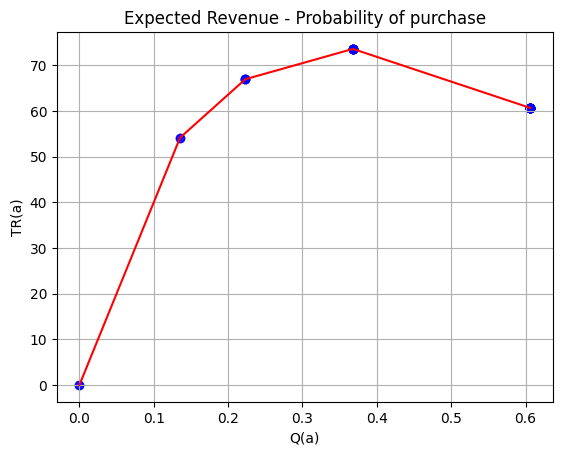

In [8]:
plt.scatter(vec_Q_price, vec_TR_price, color='blue', alpha=0.7)  # Crear la nube de puntos
plt.plot(vec_Q_price_sec, vec_TR_price_sec, color='red')  # Crear la nube de puntos
plt.title('Expected Revenue - Probability of purchase')
plt.xlabel('Q(a)')
plt.ylabel('TR(a)')
plt.grid(True)
plt.show()

In [7]:
from itertools import product

seats = np.arange(0, C + 1)
time = np.arange(0, T)

states_map = {}
for idx, (x, t) in enumerate(product(seats, time)):
    states_map[(x, t)] = idx

In [8]:
m = len(f)

action_space = combinaciones_de_n(m)

nS = (C+1)*T
nA = len(action_space)

lambd = 0.3

P_sa_s = np.zeros((nS, nA, nS))
R_sa_s = np.zeros((nS,nA,nS))


for idx, (x, t) in enumerate(product(seats, time)):
    if t != (T-1) and x != C:
        idx_1 = states_map[(x + 1, t + 1)]
        idx_2 = states_map[(x, t + 1)]

        for a_idx, a in enumerate(action_space):
            #Cambiar p_llegada para que se variable con t
            #print(p_j[list(a)].sum())
            if a == []:
                P_sa_s[idx, a_idx, idx_1] = 0
                P_sa_s[idx, a_idx, idx_2] = 1
                R_sa_s[idx, a_idx,idx_1] = 0
            else:
                P_sa_s[idx, a_idx, idx_1] = lambd*p_j[list(a)].sum()
                P_sa_s[idx, a_idx, idx_2] = 1 - lambd*p_j[list(a)].sum()
                R_sa_s[idx, a_idx,idx_1] = expected_revenue(p_j,f,a,model= "diferenciable")/p_j[list(a)].sum()

In [203]:
R_sa = np.zeros((nS,nA))

for idx, (x, t) in enumerate(product(seats,time)):
    if t != (T-1) and x != C:
        for a_idx, a in enumerate(action_space):
            if a == []:
                R_sa[idx, a_idx] = 0
                idx_1 = states_map[(x + 1, t + 1)]
                R_sa_s[idx, a_idx,idx_1] = 0
            else:
                R_sa[idx, a_idx] = lambd*expected_revenue(p_j,f,a,model= "diferenciable")
                idx_1 = states_map[(x + 1, t + 1)]
                R_sa_s[idx, a_idx,idx_1] = expected_revenue(p_j,f,a,model= "diferenciable")/p_j[list(a)].sum()


            

VALUE ITERATION

In [204]:
V_old = np.zeros(nS)
error_value = []
gamma = 1
for _ in range(60):
    V = np.max(R_sa + gamma * P_sa_s @ V_old, axis=1)
    assert np.all(V >= V_old)
    error_value.append(np.linalg.norm(V - V_old))
    V_old = V
V_value = V

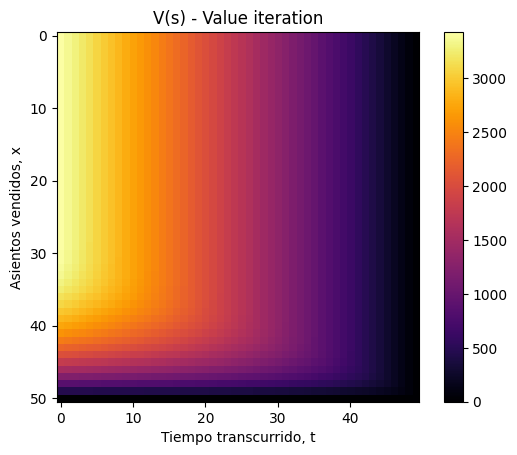

In [205]:
# Crear una matriz de ejemplo
matriz = np.zeros((C+1,T))
for idx, (x, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[x,t] = V_value[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s) - Value iteration')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()


POLICY ITERATION

In [206]:

def policy_evaluation(Pi):
    P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi)
    R_s = np.einsum('ij, ij -> i', R_sa, Pi)
    
    V = np.zeros(nS)
    for _ in range(100):
        V = R_s + gamma * P_s_s @ V
        
    Q = R_sa + gamma * P_sa_s @ V
    return V, Q

def policy_improvement(Q):
    Pi = np.zeros((nS, nA))
    for s in range(nS):
        a = np.argmax(Q[s, :])
        Pi[s, a] = 1
    return Pi

V_old = np.zeros(nS)
Q_old = np.zeros((nS, nA))
Pi = np.random.rand(nS, nA)
Pi /= Pi.sum(axis=1, keepdims=True)
error_plicy = []
for _ in range(30):
    V, Q = policy_evaluation(Pi)
    Pi = policy_improvement(Q)

    #print(V)
    #assert np.all(V >= V_old)
    #assert np.all(Q >= Q_old)
    
    error_plicy.append(np.linalg.norm(V - V_old))
    V_old = V
    Q_old = Q

V_policy = V

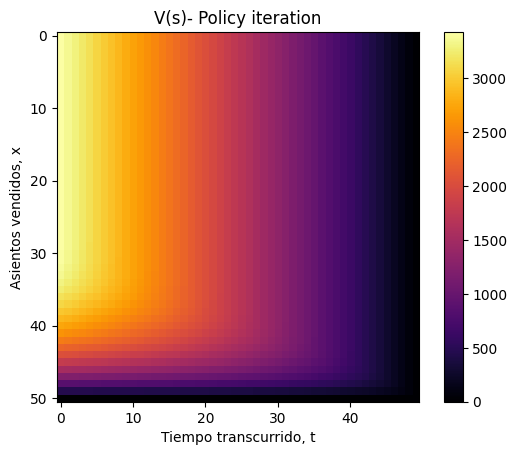

In [207]:
# Crear una matriz de ejemplo
matriz = np.zeros((C+1,T))
for idx, (x, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[x,t] = V_policy[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s)- Policy iteration')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()

In [208]:
V_policy_p = np.max(R_sa + gamma * P_sa_s @ V_policy, axis=1)
np.linalg.norm(V_policy_p - V_policy)

0.0

In [209]:
Pi = np.zeros((nS, nA))
Q =  R_sa + gamma * P_sa_s @ V

for s in range(nS):
    a = np.argmax(Q[s, :])
    Pi[s, a] = 1

P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi)
R_s = np.einsum('ij, ij -> i', R_sa, Pi)

V_value_p = R_s + gamma * P_s_s @ V_value
print(np.linalg.norm(V_value_p -V_value))

0.0


SOLUCIÓN CLASICA

In [261]:
vec_Q = np.array(vec_Q)

def opt_policy(V):
    Pi = np.zeros((nS, nA))
    for idx, (x, t) in enumerate(product(seats,time)):
        if t != (T-1) and x != C:
            BP = V[states_map[x,t+1]] - V[states_map[x+1,t+1]]
            a = np.argmax(R_sa[states_map[x,t],:]-lambd*BP*vec_Q)
            Pi[idx, a] = 1
    return Pi



V = np.zeros(nS)
Pi = opt_policy(V)

P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi)
R_s = np.einsum('ij, ij -> i', R_sa, Pi)
    
error_clasic = []

for _ in range(30):
    V, Q = policy_evaluation(Pi)
    Pi = opt_policy(V)

    #print(V)
    #assert np.all(V >= V_old)
    #assert np.all(Q >= Q_old)
    
    error_clasic.append(np.linalg.norm(V - V_old))
    V_old = V
    Q_old = Q
V_clasic = V
        

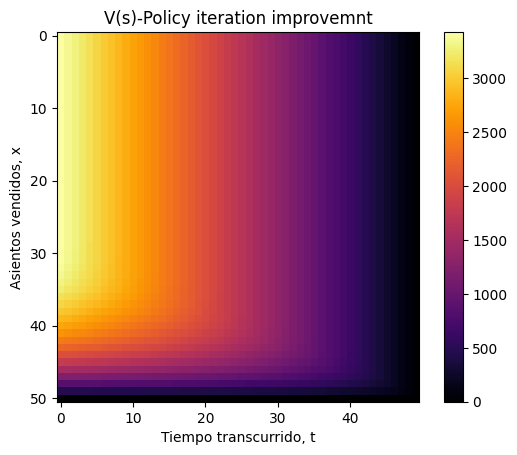

In [262]:
matriz = np.zeros((C+1,T))
for idx, (x, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[x,t] = V_clasic[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s)-Policy iteration improvemnt')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()

In [263]:
np.linalg.norm(V_clasic-V_value)

0.0

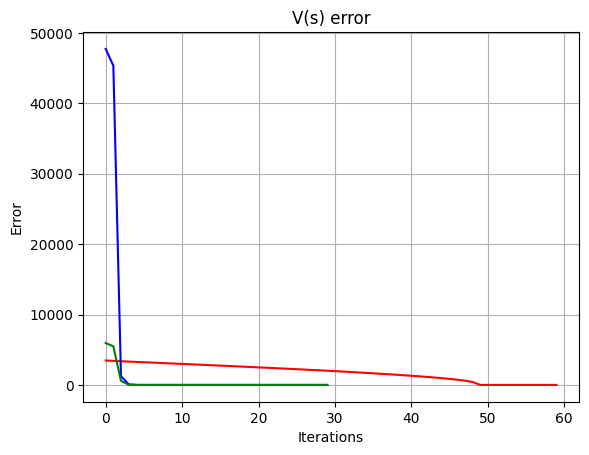

In [211]:
r = 0
plt.plot(range(r,len(error_value)), error_value[r:], color='red')
plt.plot(range(r,len(error_plicy)), error_plicy[r:], color='blue')
plt.plot(range(r,len(error_clasic)), error_clasic[r:], color='green')
plt.title('V(s) error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [267]:
V = np.zeros(nS)
Q_vec = np.array(vec_Q)

for idx, (t, x) in enumerate(product(time[::-1],seats[::-1])):
    if t != (T-1) and x != C:
        BP = V[states_map[x,t+1]] - V[states_map[x+1,t+1]]
        a = np.argmax(R_sa[states_map[x,t],:]-lambd*BP*Q_vec)
        V[states_map[x,t]] = V[states_map[x,t+1]] + R_sa[states_map[x,t],a] - lambd*BP*Q_vec[a]


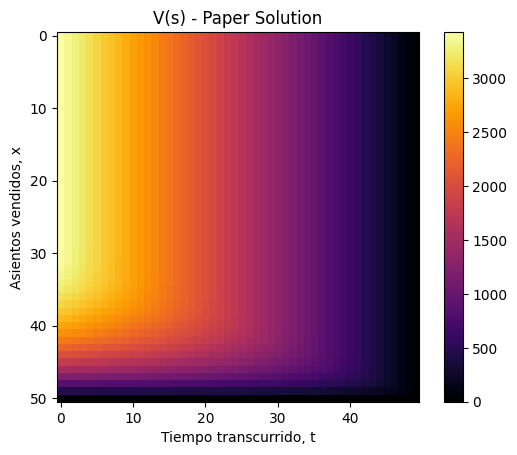

In [268]:
matriz = np.zeros((C+1,T))
for idx, (s, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[s,t] = V[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s) - Paper Solution')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()

In [269]:
print(np.linalg.norm(V_value -  V_policy))
print(np.linalg.norm(V_policy - V_clasic))
print(np.linalg.norm(V_policy - V))

0.0
0.0
7.278370283913077e-11


In [290]:
V = np.zeros(nS)
sec = conjuntos_secuenciales(m-1)
Q_vec = np.array(vec_Q)

for idx, (t, x) in enumerate(product(time[::-1],seats[::-1])):
    if t != (T-1) and x != C:
        BP = V[states_map[x,t+1]] - V[states_map[x+1,t+1]]
        old_Q = 0
        old_TR = 0
        opt_a = 0
        a_idx = 0
        for a_idx, conjunto_a in enumerate(sec[1:], start=1):
            Q_k = p_reserva(p_j,conjunto_a)
            TR_k = expected_revenue(p_j,f,conjunto_a,model = "diferenciable")
            MR_k = (TR_k - old_TR)/(Q_k - old_Q)
            if MR_k < BP:
                opt_a = a_idx -1
                break
            opt_a = a_idx
            old_Q = Q_k
            old_TR = TR_k
        
        a = action_space.index(sec[opt_a])
        V[states_map[x,t]] = V[states_map[x,t+1]] + R_sa[states_map[x,t],a] - lambd*BP*Q_vec[a]

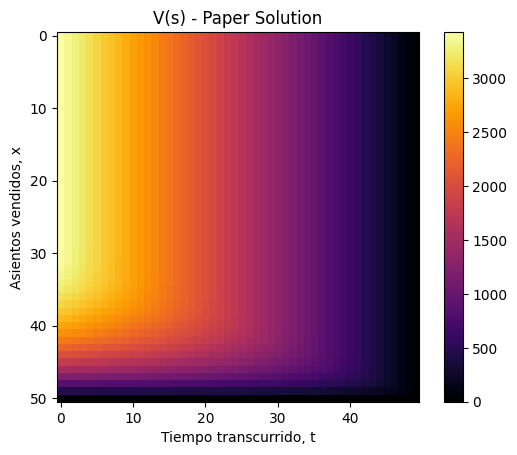

In [291]:
matriz = np.zeros((C+1,T))
for idx, (s, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[s,t] = V[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s) - Paper Solution')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()

In [292]:
print(np.linalg.norm(V_value -  V_policy))
print(np.linalg.norm(V_policy - V_clasic))
print(np.linalg.norm(V_policy - V))

0.0
0.0
7.278370283913077e-11
